## Objective

The rising potential of this comparatively under-the-radar market fuels the need for an ML-based solution to develop a dynamic pricing strategy for used and refurbished smartphones. ReCell, a startup aiming to tap the potential in this market, has hired you as a data scientist. They want you to analyze the data provided and build a linear regression model to <code style = 'background: yellow; color: black'>predict the price of a used phone and identify factors that significantly influence it.</code>


## Importing necessary libraries and data

In [203]:
# Import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# to split the data into train and test
from sklearn.model_selection import train_test_split

# to check model performance and scalers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# to build linear regression_model using statsmodels
import statsmodels.api as sm

# to limit outputs to 3 decimal places. 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [204]:
# Read in the data
data = pd.read_csv('used_phone_data.csv')

## Data Overview

- Observations
- Sanity checks

In [205]:
# Check the overall shape of the data
data.shape

(3571, 15)

In [206]:
# Check datatypes and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3571 entries, 0 to 3570
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand_name        3571 non-null   object 
 1   os                3571 non-null   object 
 2   screen_size       3571 non-null   float64
 3   4g                3571 non-null   object 
 4   5g                3571 non-null   object 
 5   main_camera_mp    3391 non-null   float64
 6   selfie_camera_mp  3569 non-null   float64
 7   int_memory        3561 non-null   float64
 8   ram               3561 non-null   float64
 9   battery           3565 non-null   float64
 10  weight            3564 non-null   float64
 11  release_year      3571 non-null   int64  
 12  days_used         3571 non-null   int64  
 13  new_price         3571 non-null   float64
 14  used_price        3571 non-null   float64
dtypes: float64(9), int64(2), object(4)
memory usage: 418.6+ KB


In [207]:
# Collect a sample of the data to observe the columns and values
# I use 'sample' instead of 'head' to ensure a random spread of possible values

data.sample(5)

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price
3454,Honor,Android,19.370,yes,no,13.000,32.000,128.000,8.000,4000.000,182.000,2019,431,314.865,157.310
2236,Oppo,Android,15.240,yes,no,16.000,20.000,64.000,4.000,3200.000,152.000,2017,607,319.620,127.920
2606,Samsung,Others,10.160,no,no,3.150,0.300,16.000,4.000,1500.000,112.000,2015,652,79.740,31.900
1948,Micromax,Android,10.160,no,no,2.000,0.300,16.000,4.000,1450.000,143.000,2015,740,60.110,24.240
2166,Nokia,Android,12.700,no,no,5.000,2.000,16.000,4.000,2000.000,190.000,2014,1093,100.760,30.350


#### Observations:
<ul>
    <li>Mostly numerical data, a few strings.</li>
    <li>4g and 5g are strings with 'yes' or 'no', need to convert these to binary.</li>
    <li>'brand_name' and 'os' should be converted to categories for easier analysis.</li> 
    <li>A few columns - such as 'main_camera_mp' are missing data</li>
</ul>


## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

In [208]:
# convert the object columns to categories for easier analysis

cols_to_cat = ['brand_name', 'os', '4g', '5g']

data[cols_to_cat] = data[cols_to_cat].astype('category')

In [209]:
# Find number of unique entries to get an idea of the data and the interesting variables

data.nunique()

brand_name            34
os                     4
screen_size          127
4g                     2
5g                     2
main_camera_mp        44
selfie_camera_mp      37
int_memory            16
ram                   14
battery              354
weight               613
release_year           8
days_used            930
new_price           3099
used_price          3044
dtype: int64

#### Univariate Analysis

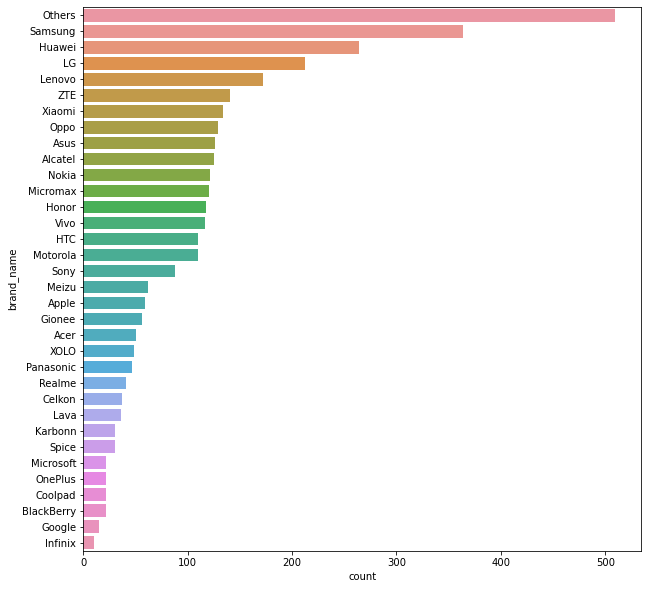

In [210]:
# Plot the distribution of brands
plt.figure(figsize = (10,10))
sns.countplot(data = data, y = 'brand_name', order = data['brand_name'].value_counts().index);
plt.show()

<ul>
    <li>'Others' brand makes up the largest portion of used phones</li>
    <li>'Infinix' makes up the smallest portion.</li>
</ul>

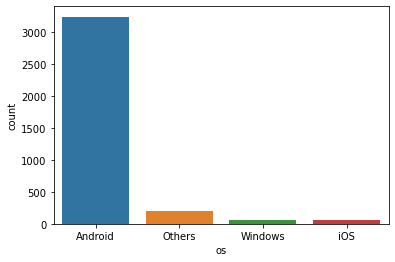

In [211]:
# Plot the operating system distribution

sns.countplot(data = data, x = 'os');

<ul>
    <li>Android operating systems make up the vast majority of used phones.</li>
</ul>

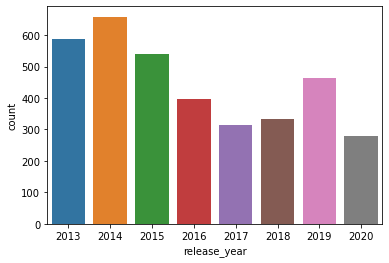

In [212]:
# Plot the release year distribution
sns.countplot(data = data, x = 'release_year');

<ul>
    <li>Used phones range from 2013 to 2020 release dates.</li>
    <li>Visually, it appears the majority of the used phones were released 2013 - 2016.</li>
    <li>There is large portion of phones in the dataset that were released in 2019.</li>
</ul>

In [213]:
# I created a function to quickly look at the distributions of a number of variables at the same time. 
# This function allows multiple entries at a time. 

def hist_plots(data, list):
    
    num_graphs = len(list)
    ax_list = []
    count = 0
    
    for i in list:
        ax_list.append(i)
        
    fig, ax_list = plt.subplots(1, num_graphs, figsize = (num_graphs * 10, 10))
    
    for i in list:
        
        sns.histplot(data = data, ax = ax_list[count], x = i, kde = True)  
        ax_list[count].axvline(data[i].median(), color = 'red')
        
        count += 1
        
    plt.show()

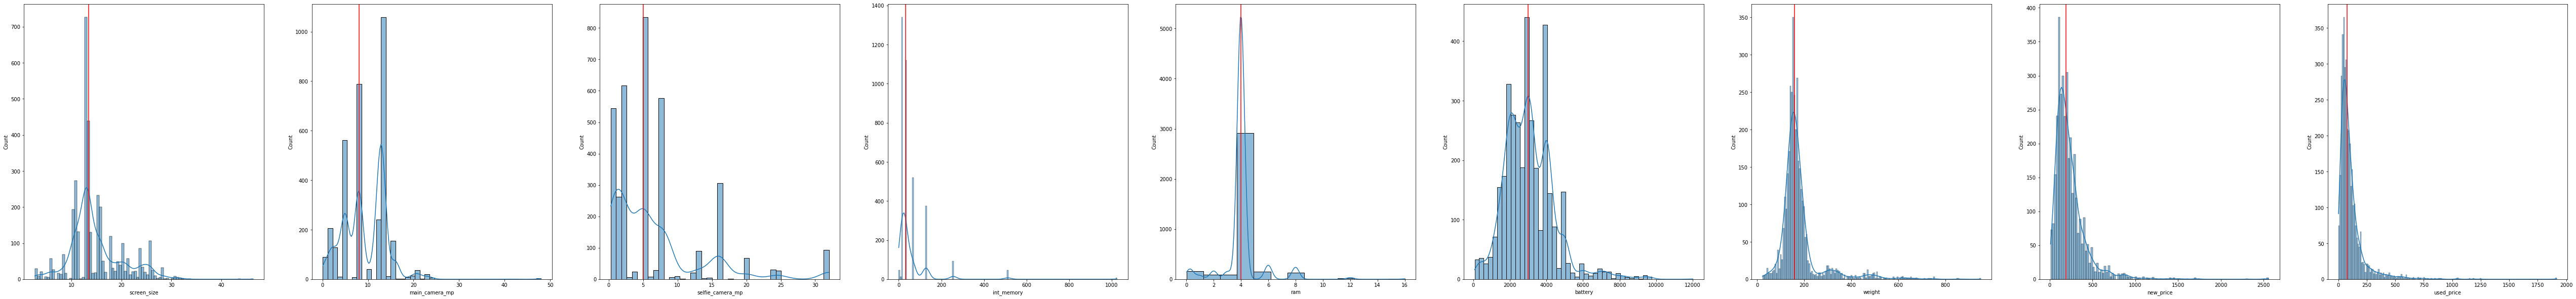

In [214]:
# Gather the float datatype columns and save them to a list.
# Call the hist_plot function to get the distributions of each of the float variables - double-click to expand the charts.

float_cols = data.select_dtypes(include = float).columns.tolist()

hist_plots(data, float_cols)

<ul>
    <li>34 brands represented</li>
    <li>4 operating systems</li>
    <li>8 different manufactured years</li>
    <li>Due to the scales, the battery and weight columns could use some sort of transformation. (MixMax or Scaler)</li>
    <li>New price and Used price could likely benefit from log transformation.</li>
</ul>

#### Bivariate Analysis


In [215]:
# # Gather the columns that are a number (ie. int or float)

# pairplot_data = data.select_dtypes(include = np.number)

# pairplot_data.columns

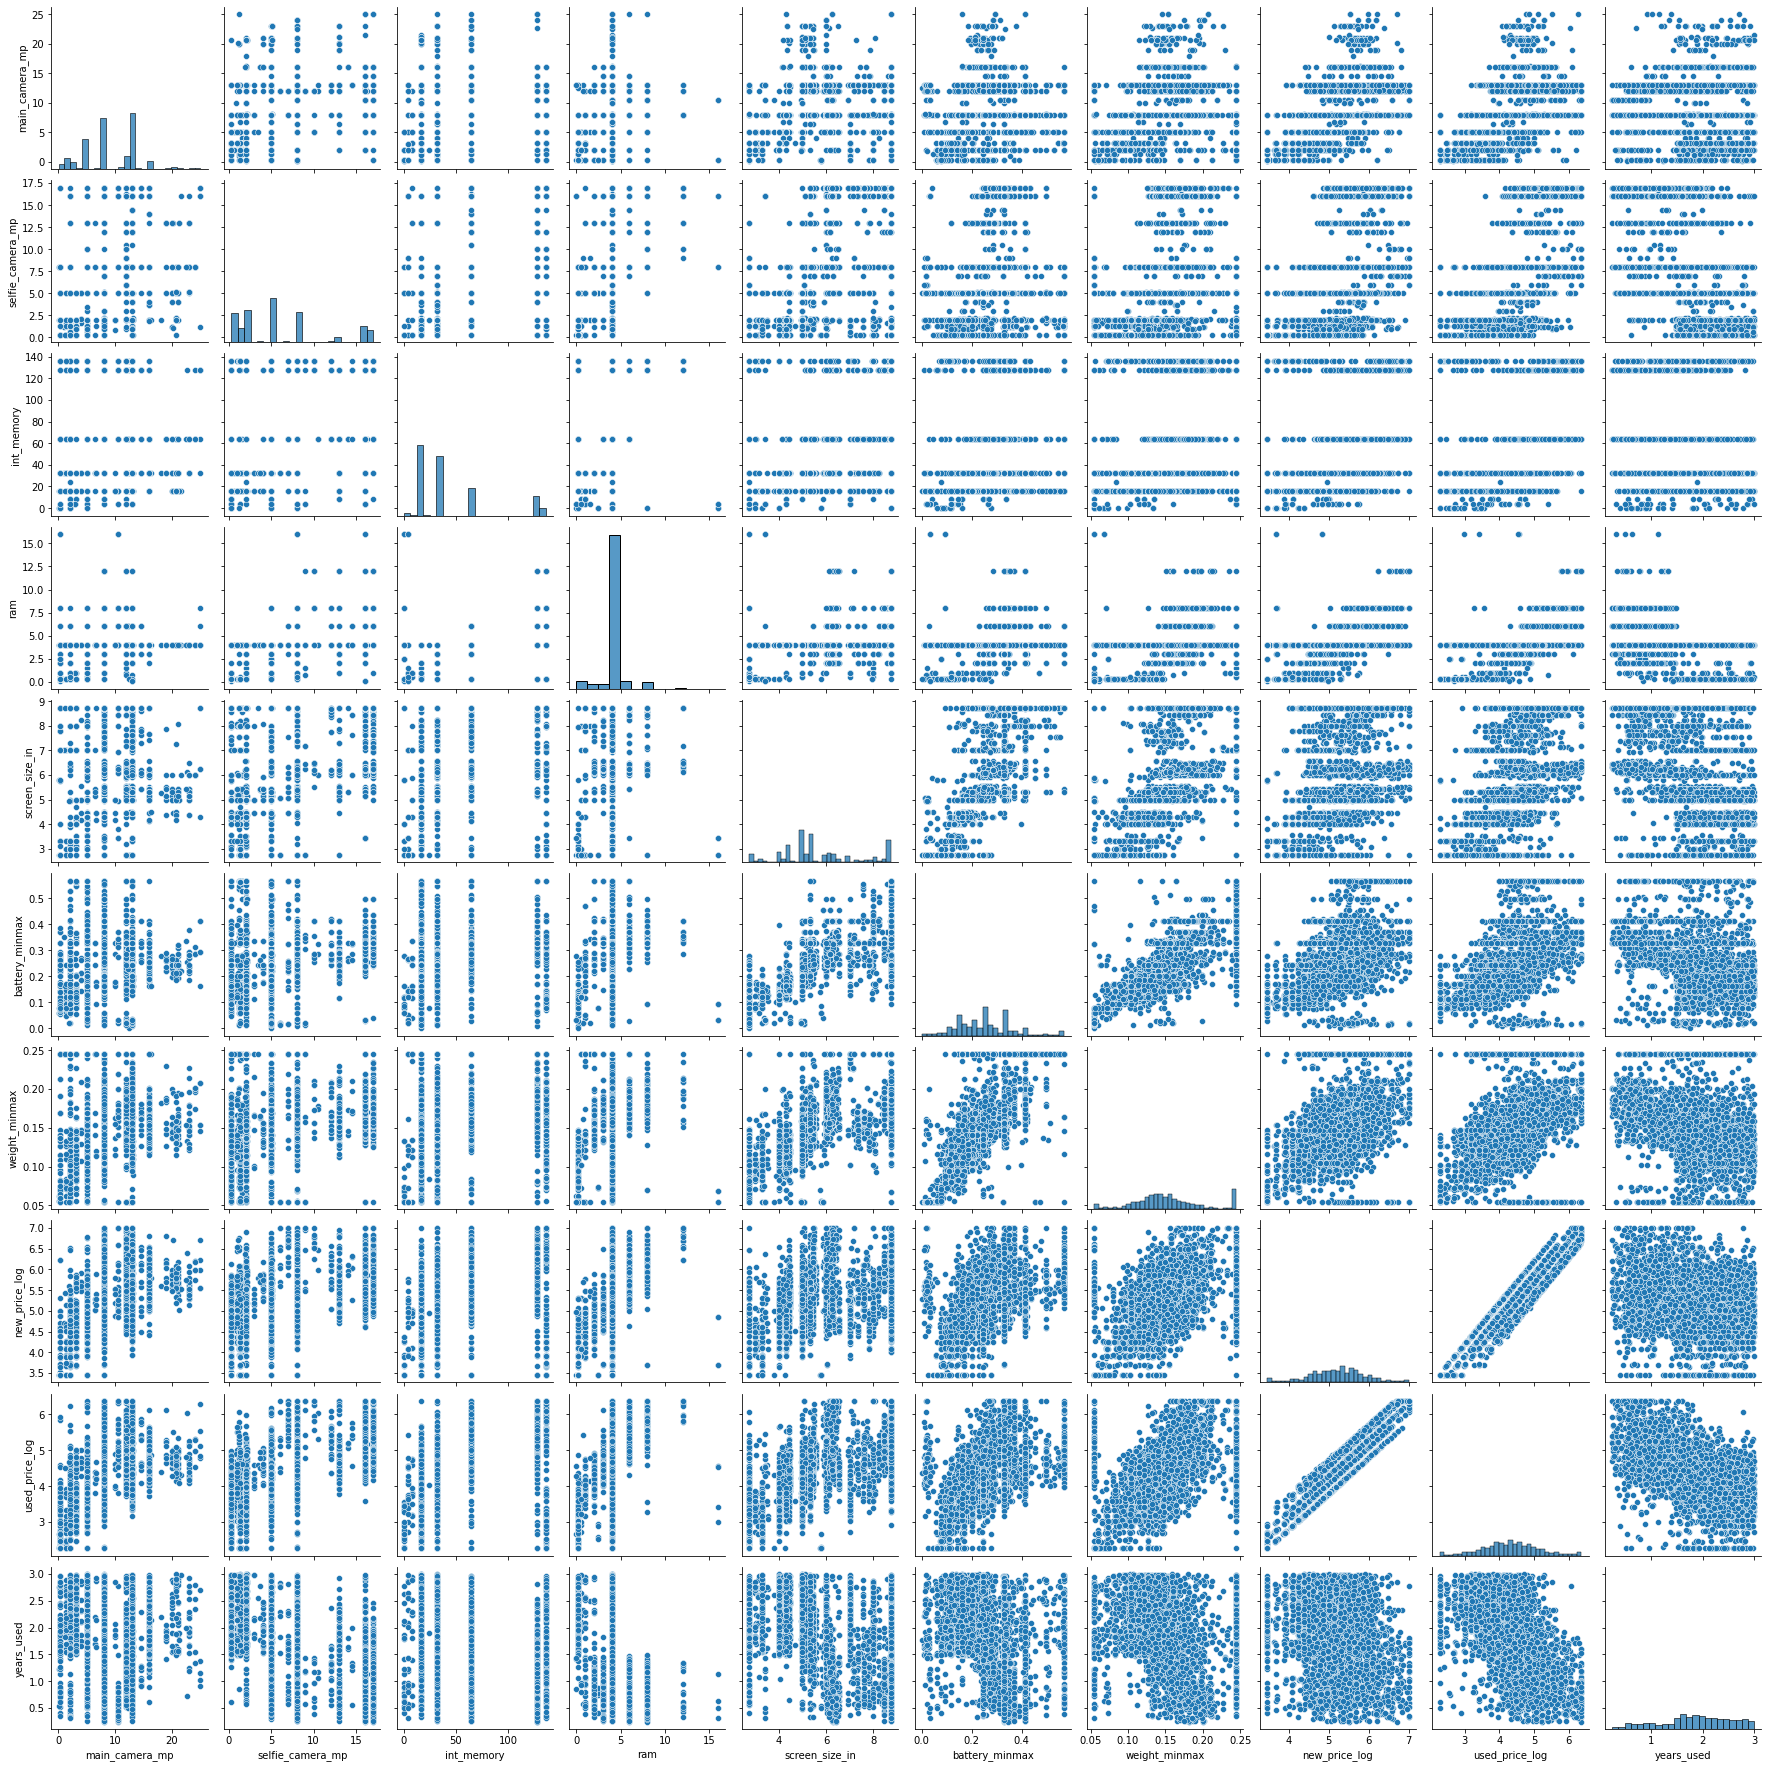

In [216]:
# Plot the numerical data against itself
sns.pairplot(data = pairplot_data);

<ul>
    <li>Apparent correlation between new and old price, battery and weight, and battery, weight, and screensize.</li>
    <li>Some of the numerical is not continuous and data appears categorical, causing straight vertical/horizontal lines.</li>
</ul>

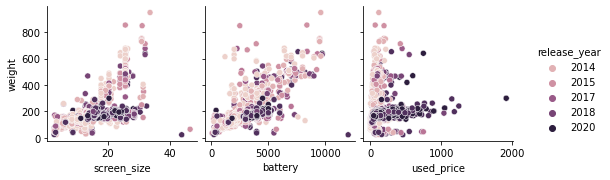

In [217]:
# Plot interesting interactions between variables
sns.pairplot(data = data, x_vars = ['screen_size', 'battery', 'used_price'], y_vars = 'weight', hue = 'release_year');

<ul>
    <li>Interesting trend when setting the hue as release year, as the technology has gotten better (sooner years), the weight hits a ceiling while the other variables continue to grow.</li>
</ul>

Questions:

1. What does the distribution of used phone prices look like?

In [218]:
#Check the summary stats for the used_price variable.

data['used_price'].describe().T

count   3571.000
mean     109.880
std      121.501
min        2.510
25%       45.205
50%       75.530
75%      126.000
max     1916.540
Name: used_price, dtype: float64

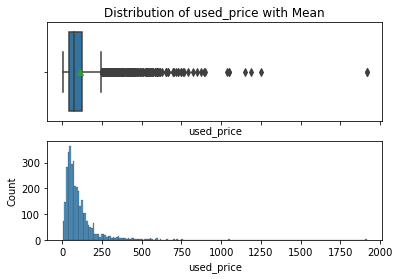

In [219]:
# Create plot with 2 subplots to show the boxplot and histogram

fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
ax1.set_title('Distribution of used_price with Mean')
sns.boxplot(data = data, ax = ax1, x = 'used_price', showmeans = True)
sns.histplot(data = data, ax = ax2, x = 'used_price')

plt.show()

<ul>
    <li>The distribution for used price is heavily skewed right. This means there are many outliers where the used_price is much more than the median. 
        This distribution may benefit from transformation.</li>
</ul>

2. What percentage of the used phone market is dominated by Android devices?

In [220]:
# Calculate the relative percentages of the operating systems represented

data['os'].value_counts(normalize = True)

Android   0.909
Others    0.057
Windows   0.019
iOS       0.016
Name: os, dtype: float64

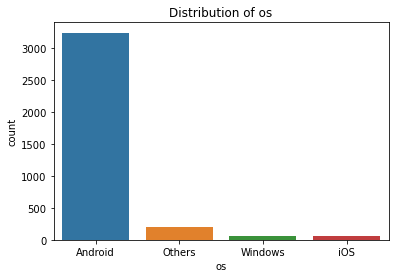

In [221]:
# Plot the distribution of os
plt.title('Distribution of os')
sns.countplot(data = data, x = 'os');
plt.show()

Android makes up about 91% of the used phone market. 

3. The amount of RAM is important for the smooth functioning of a phone. How does the amount of RAM vary with the brand?

In [222]:
# Find the range of ram for each brand represented.

data.groupby('brand_name')['ram'].describe()

,count,mean,std,min,25%,50%,75%,max
brand_name,,,,,,,,
Acer,51.000,3.902,0.500,1.000,4.000,4.000,4.000,4.000
Alcatel,125.000,3.426,1.248,0.250,4.000,4.000,4.000,4.000
Apple,59.000,4.000,0.491,2.000,4.000,4.000,4.000,6.000
Asus,126.000,4.048,0.591,2.000,4.000,4.000,4.000,8.000
BlackBerry,22.000,3.830,0.800,0.250,4.000,4.000,4.000,4.000
Celkon,37.000,1.466,1.780,0.250,0.250,0.250,4.000,4.000
Coolpad,22.000,3.955,0.213,3.000,4.000,4.000,4.000,4.000
Gionee,56.000,3.933,0.501,0.250,4.000,4.000,4.000,4.000
Google,15.000,4.533,0.915,4.000,4.000,4.000,5.000,6.000


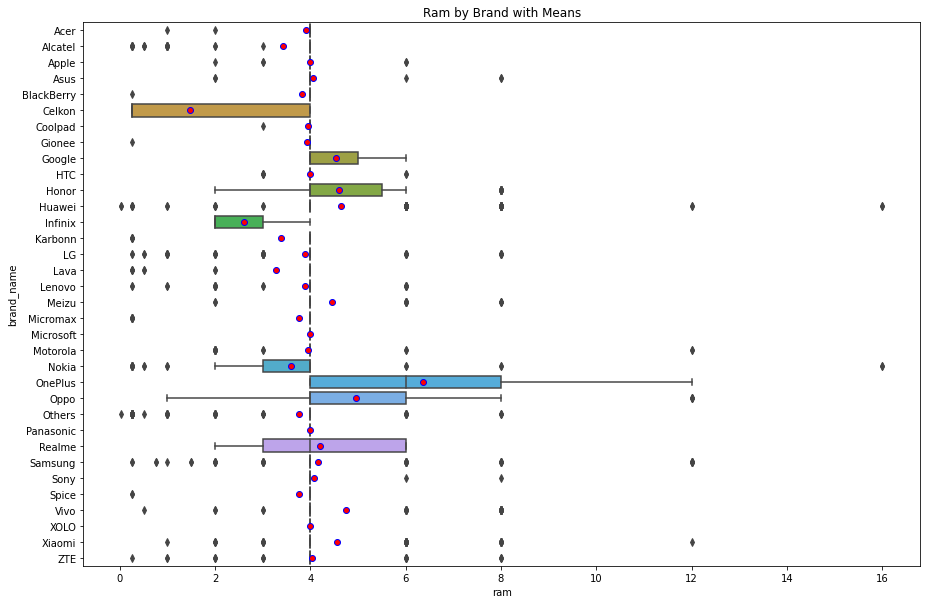

In [223]:
# Graph the spread of ram grouped by the company name. Means shown for each company.
plt.figure(figsize = (15, 10))
plt.title('Ram by Brand with Means')
sns.boxplot(data = data, x = 'ram', y = 'brand_name', showmeans = True, meanprops={"marker":"o","markerfacecolor":"red", "markeredgecolor":"blue"});
plt.show()

From this boxplot it appears 'ram' might be better treated as a categorical variable. 


4. A large battery often increases a phone's weight, making it feel uncomfortable in the hands. How does the weight vary for phones offering large batteries (more than 4500 mAh)?

In [224]:
#Create a temp dataframe for large battery samples

large_battery = data[data['battery'] > 4500]
large_battery.sample(5)

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price
665,Apple,iOS,19.210,yes,no,8.000,7.000,64.000,4.000,5124.000,300.500,2019,250,450.410,312.410
1989,Micromax,Android,20.320,no,no,5.000,2.000,16.000,4.000,4800.000,118.000,2013,1032,171.390,51.350
1330,Huawei,Android,25.560,yes,no,8.000,8.000,64.000,4.000,7500.000,475.000,2018,708,300.030,120.040
174,Vivo,Android,20.800,yes,no,13.000,16.000,128.000,4.000,5000.000,190.500,2019,500,189.770,94.890
2671,Samsung,Android,25.560,yes,no,3.150,1.300,16.000,4.000,6800.000,487.000,2014,737,308.690,123.340


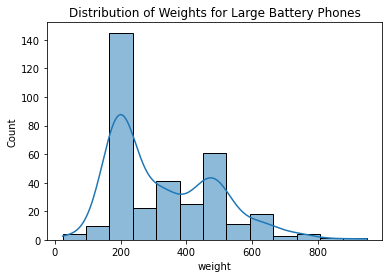

In [225]:
#Plot the weight distribution of large batter phones

plt.title('Distribution of Weights for Large Battery Phones')
sns.histplot(data = large_battery, x = 'weight', kde = True);
plt.show()

The distribution of weight appears non-normal and right skewed. The majority of large phones fall into the 200 units range.

5. Bigger screens are desirable for entertainment purposes as they offer a better viewing experience. How many phones are available across different brands with a screen size larger than 6 inches?

In [226]:
# Convert centimeters to inches

data['screen_size_in'] = data['screen_size'].apply(lambda x: x * 0.39371)
data.sample(5, random_state = 1)

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price,screen_size_in
2501,Samsung,Android,13.490,yes,no,13.000,13.000,32.000,4.000,3600.000,181.000,2017,683,198.680,79.470,5.311
2782,Sony,Android,13.810,yes,no,NaN,8.000,32.000,4.000,3300.000,156.000,2019,195,198.150,149.100,5.437
605,Others,Android,12.700,yes,no,8.000,5.000,16.000,4.000,2400.000,137.000,2015,1048,161.470,48.390,5.000
2923,Vivo,Android,19.370,yes,no,13.000,16.000,64.000,4.000,3260.000,149.300,2019,375,211.880,138.310,7.626
941,Others,Others,5.720,no,no,0.300,0.300,32.000,0.250,820.000,90.000,2013,883,29.810,8.920,2.252


In [227]:
# Create temporary dataframe for large screen samples

large_screen = data[data['screen_size_in'] > 6]
large_screen.sample(5)

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price,screen_size_in
211,ZTE,Android,25.560,yes,yes,NaN,12.000,128.000,6.000,5100.000,210.000,2020,278,311.110,209.720,10.063
3486,Motorola,Android,15.880,yes,no,NaN,16.000,64.000,4.000,5000.000,199.000,2020,156,212.492,159.420,6.252
3303,Honor,Android,25.240,yes,yes,13.000,16.000,64.000,6.000,4300.000,203.000,2020,329,271.142,175.110,9.937
2470,Samsung,Android,15.240,yes,no,12.000,24.000,128.000,4.000,3300.000,168.000,2018,385,280.030,184.030,6.000
471,Acer,Android,17.780,no,no,0.300,2.000,16.000,4.000,2955.000,323.000,2014,1082,129.520,38.840,7.000


In [228]:
# Check the shape of the new df to see how many of the original entries have large screens.
large_screen.shape

(1364, 16)

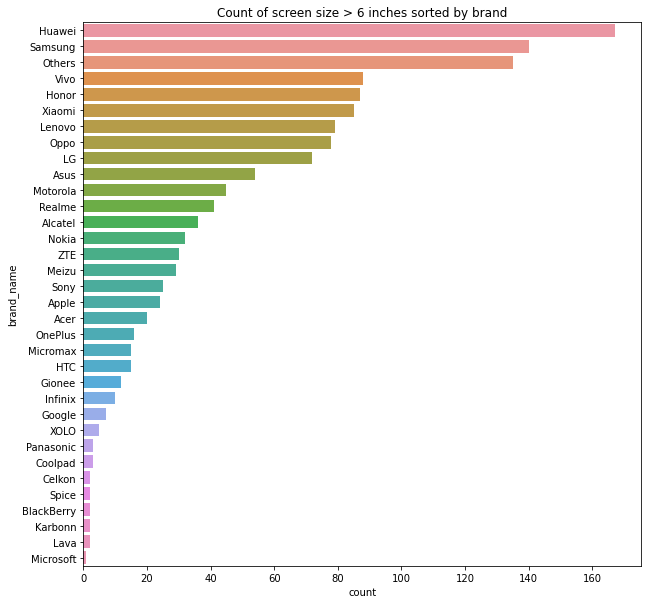

In [229]:
# Plot the large screen distribution by brand
plt.figure(figsize = [10, 10])
plt.title('Count of screen size > 6 inches sorted by brand')
sns.countplot(data = large_screen, y = 'brand_name', order = large_screen['brand_name'].value_counts().index)
plt.show()

All brands have at least one phone that has a >6 inch screen.

Huawei has the largest number of phones with large screens.

There are a total of 1364 phones with large screens in the data set. 

6. Budget phones nowadays offer great selfie cameras, allowing us to capture our favorite moments with loved ones. What is the distribution of budget phones offering greater than 8MP selfie cameras across brands?

In [230]:
# Create temp dataframe for selfie cameras greater than 8 MP

eight_mp = data.loc[data['selfie_camera_mp'] > 8]
eight_mp.sample(5)

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price,screen_size_in
2973,Vivo,Android,13.810,yes,no,16.000,16.000,64.000,4.000,4000.000,183.500,2016,791,680.670,272.380,5.437
2229,Oppo,Android,18.890,yes,no,16.000,25.000,64.000,4.000,3400.000,158.000,2018,560,272.380,136.240,7.437
359,Oppo,Android,15.880,yes,no,8.000,25.000,128.000,6.000,3600.000,169.500,2019,344,280.940,181.940,6.252
3420,Xiaomi,Android,25.880,yes,yes,NaN,20.000,256.000,8.000,4500.000,208.000,2020,112,713.991,535.920,10.189
278,Huawei,Android,21.430,yes,no,13.000,32.000,128.000,8.000,3500.000,171.000,2019,520,391.400,195.670,8.437


In [231]:
# Separate the 8MP selfie cameras by brand
eight_mp['brand_name'].value_counts()

Huawei        91
Vivo          78
Oppo          75
Xiaomi        65
Samsung       60
Honor         43
Others        34
LG            32
Motorola      26
Meizu         24
ZTE           20
HTC           20
Realme        18
OnePlus       18
Sony          14
Lenovo        14
Nokia         10
Asus           6
Gionee         4
Infinix        4
Coolpad        3
Micromax       2
Panasonic      2
BlackBerry     2
Acer           1
Apple          0
XOLO           0
Spice          0
Google         0
Karbonn        0
Lava           0
Microsoft      0
Alcatel        0
Celkon         0
Name: brand_name, dtype: int64

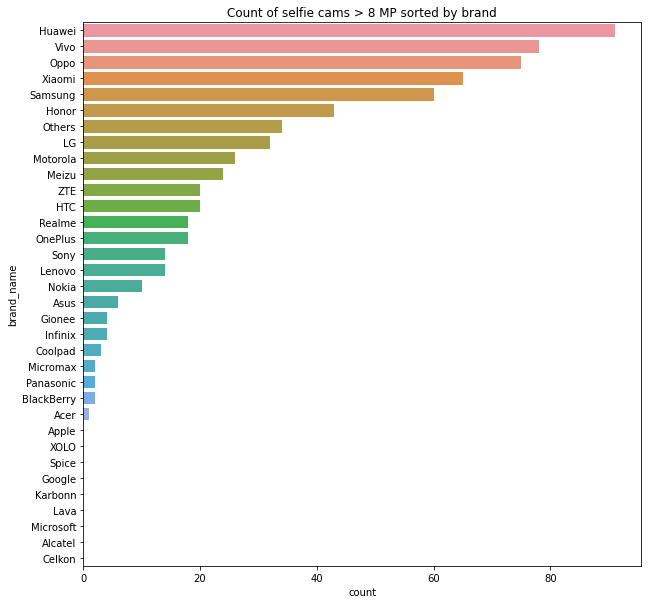

In [232]:
# Plot the distribution

plt.figure(figsize = [10, 10])
plt.title('Count of selfie cams > 8 MP sorted by brand')
sns.countplot(data = eight_mp, y = 'brand_name', order = eight_mp['brand_name'].value_counts().index)
plt.show()

Once again Huawei is at the top, it has the most phones with >8 MP selfie cameras.

There are quite a few brands that have 0 phones in the dataset with >8 MP selfie cameras.

7. Which attributes are highly correlated with the used phone price?

In [233]:
# Generate the correlation matrix and isolate the used price column
corr = data.corr()
used_price_corr = corr[['used_price']]

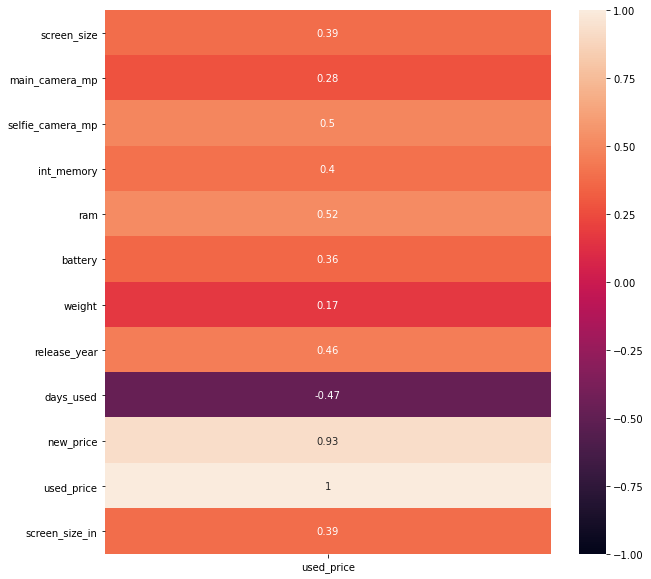

In [234]:
# Plot the correlation matrix with used price
plt.figure(figsize = (10, 10))
sns.heatmap(used_price_corr, annot = used_price_corr, vmin = -1, vmax = 1)
plt.show()

New Price is VERY positively correlated with used price.

Most variables except for 'days_used' and 'weight' are moderately positively correlated.

Days used is moderately negatively correlated with used price.

Weight is the least correlated variable with used price.

## Data Preprocessing

- Missing value treatment


In [235]:
# Check for missing data

data.isnull().sum()

brand_name            0
os                    0
screen_size           0
4g                    0
5g                    0
main_camera_mp      180
selfie_camera_mp      2
int_memory           10
ram                  10
battery               6
weight                7
release_year          0
days_used             0
new_price             0
used_price            0
screen_size_in        0
dtype: int64

In [236]:
# FInd the numerical columns in the data set

num_cols = data.select_dtypes(include = np.number).columns.tolist()
num_cols

['screen_size',
 'main_camera_mp',
 'selfie_camera_mp',
 'int_memory',
 'ram',
 'battery',
 'weight',
 'release_year',
 'days_used',
 'new_price',
 'used_price',
 'screen_size_in']

In [237]:
# Fill the numerical columns with the median value

data[num_cols] = data[num_cols].fillna(data[num_cols].median())

In [238]:
# Recheck the data for null values

data.isnull().sum()

brand_name          0
os                  0
screen_size         0
4g                  0
5g                  0
main_camera_mp      0
selfie_camera_mp    0
int_memory          0
ram                 0
battery             0
weight              0
release_year        0
days_used           0
new_price           0
used_price          0
screen_size_in      0
dtype: int64

- Feature engineering (if needed)

#### Screen Size

Screen size in inches was added during EDA, now I need to delete one of the screen size columns.

I will keep the screen size in inches in an attempt to keep the scales of the variables somewhat similar.

In [239]:
# Drop screen size column

data.drop('screen_size', axis = 1, inplace = True)
data.sample(5)

,brand_name,os,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price,screen_size_in
2415,Others,Android,no,no,3.150,0.300,512.000,0.250,2100.000,150.000,2014,818,61.290,18.380,9.063
215,ZTE,Android,yes,no,14.500,8.000,128.000,4.000,5000.000,190.000,2019,343,130.620,85.780,9.063
3460,Huawei,Android,yes,yes,10.500,16.000,128.000,8.000,4200.000,209.000,2020,162,730.991,548.870,9.626
3090,Xiaomi,Android,yes,no,16.000,5.000,16.000,4.000,4050.000,164.000,2016,884,160.370,48.240,5.311
2493,Samsung,Android,yes,no,16.000,8.000,32.000,4.000,3000.000,172.000,2017,610,268.750,107.470,5.374


#### Categorical Variables

As mentioned above, the ram variable is not continuous and would make more sense as a category. The same is true for internal memory and release year.

In [240]:
# Convert release year into a categorical data type.

data['release_year'] = data['release_year'].astype('category')

In [241]:
# Check the dataframe info to confirm progress
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3571 entries, 0 to 3570
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   brand_name        3571 non-null   category
 1   os                3571 non-null   category
 2   4g                3571 non-null   category
 3   5g                3571 non-null   category
 4   main_camera_mp    3571 non-null   float64 
 5   selfie_camera_mp  3571 non-null   float64 
 6   int_memory        3571 non-null   float64 
 7   ram               3571 non-null   float64 
 8   battery           3571 non-null   float64 
 9   weight            3571 non-null   float64 
 10  release_year      3571 non-null   category
 11  days_used         3571 non-null   int64   
 12  new_price         3571 non-null   float64 
 13  used_price        3571 non-null   float64 
 14  screen_size_in    3571 non-null   float64 
dtypes: category(5), float64(9), int64(1)
memory usage: 298.7 KB


#### 4g and 5g variables

Currently 4g and 5g are integer variables. They would make more sense as categorical variables. However, since they currently are their own columns and cannot be one-hot encoded due to having other options, I will create a new column and add 'None' as an option. 

In [242]:
# Create a new column to turn 4g an 5g into a single categorical variable.

network_condis = [
    (data['4g'] == 'yes') & (data['5g'] == 'yes'),
    (data['4g'] == 'yes') & (data['5g'] == 'no'), 
    (data['4g'] == 'no') & (data['5g'] == 'yes'), 
    (data['4g'] == 'no') & (data['5g'] == 'no')
         ]

network_vals = ['Both', '4g', '5g', 'Other']

data['network'] = np.select(network_condis, network_vals)

In [243]:
# Drop the original 4g and 5g columns

data.drop(['4g', '5g'], axis = 1, inplace = True)

In [244]:
# Cast the new column as a category

data['network'] = data['network'].astype('category')
data.sample(5)

,brand_name,os,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price,screen_size_in,network
1923,Micromax,Android,8.000,5.000,16.000,4.000,2500.000,159.000,2016,1073,79.890,23.960,5.311,Other
214,ZTE,Android,14.500,16.000,64.000,3.000,3200.000,165.000,2019,347,160.880,103.340,6.189,4g
1350,Huawei,Android,13.000,8.000,32.000,4.000,7500.000,498.000,2018,522,300.480,150.410,10.500,4g
1082,Gionee,Android,12.000,8.000,64.000,4.000,6020.000,215.000,2017,623,460.230,184.120,6.000,4g
1073,Others,Android,8.000,2.000,16.000,4.000,1700.000,150.500,2013,944,220.290,66.320,4.311,Other


#### Transformations

<li>Due to the scales, the battery and weight columns could use some sort of transformation. (MixMax or Scaler)</li>
    <li>New price and Used price could likely benefit from log transformation.</li>

In [245]:
# Initialize the standard and minmax scalers
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

Battery Transformation

In [246]:
# Create new columns with transformed data
data['battery_z'] = std_scaler.fit_transform(data[['battery']])
data['battery_minmax'] = minmax_scaler.fit_transform(data[['battery']])

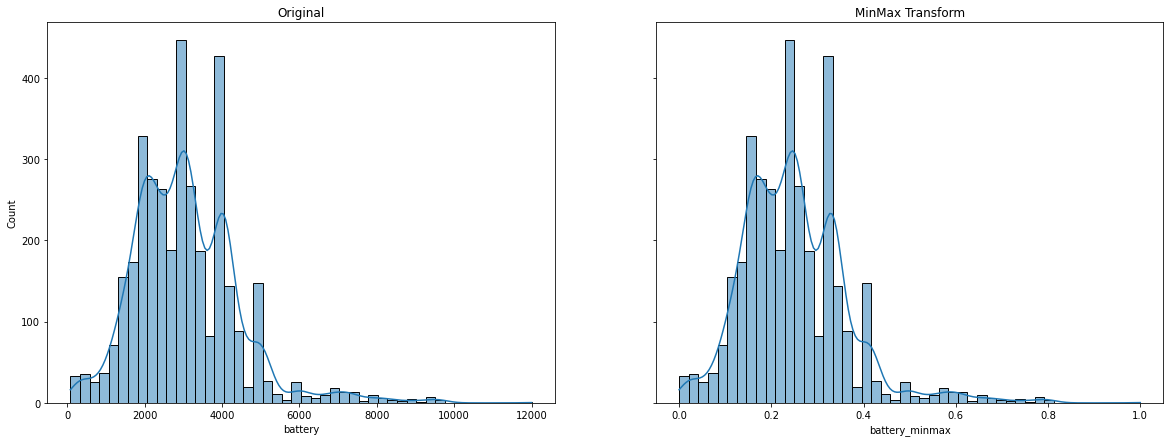

In [247]:
# Plot the original and transformed data side-by-side

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (20,7))
fig, (ax1, ax3) = plt.subplots(1, 2, sharey = True, figsize = (20,7))

ax1.set_title('Original')
# ax2.set_title('Std Transform')
ax3.set_title('MinMax Transform')

sns.histplot(data, x = 'battery', ax = ax1, kde = True)
# sns.histplot(data, x = 'battery_z', ax = ax2, kde = True)
sns.histplot(data, x = 'battery_minmax', ax = ax3, kde = True)
plt.show()

In order to keep positive numbers, I will use the min max transform for the battery variable. Therefore I need to drop the other columns for battery size. 

In [248]:
# Drop the unneeded columns
data.drop(['battery', 'battery_z'], axis = 1, inplace = True)

Weight Transform

In [249]:
#Create new columns with transformed data
data['weight_z'] = std_scaler.fit_transform(data[['weight']])
data['weight_minmax'] = minmax_scaler.fit_transform(data[['weight']])

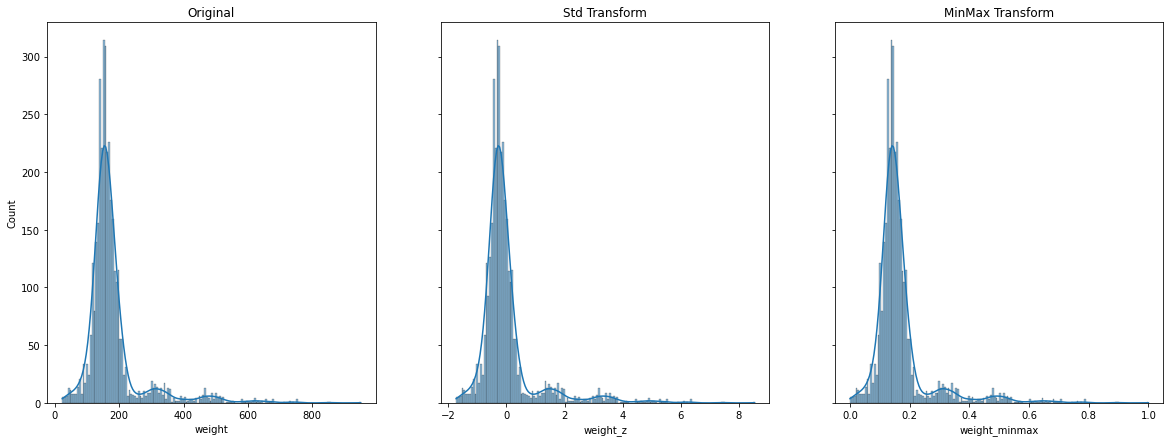

In [250]:
# Plot the original and transformed data side-by-side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (20,7))

ax1.set_title('Original')
ax2.set_title('Std Transform')
ax3.set_title('MinMax Transform')

sns.histplot(data, x = 'weight', ax = ax1, kde = True)
sns.histplot(data, x = 'weight_z', ax = ax2, kde = True)
sns.histplot(data, x = 'weight_minmax', ax = ax3, kde = True)
plt.show()

Similar to battery size, I want to keep positive numbers for weight. Therefore I will use the minmax transformation on the data and delete the others.

In [251]:
# Drop the unneeded columns
data.drop(['weight', 'weight_z'], axis = 1, inplace = True)

Log Transformations

New Price

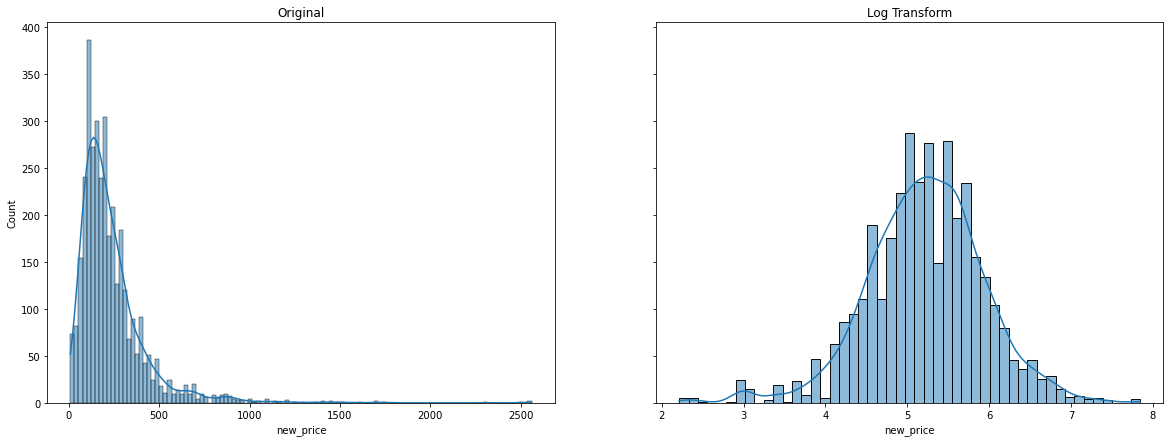

In [252]:
# Plot the original and transformed data
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (20,7))

ax1.set_title('Original')
ax2.set_title('Log Transform')


sns.histplot(data, x = 'new_price', ax = ax1, kde = True)
sns.histplot(data, x = np.log(data['new_price']), ax = ax2, kde = True)

plt.show()

The log transformation of new price is much more normal than the original, so we will keep the transformed values. 

In [253]:
# Create new column for transformed data and drop unneeded column
data['new_price_log'] = np.log(data['new_price'])
data.drop('new_price', axis = 1, inplace = True)

Used Price

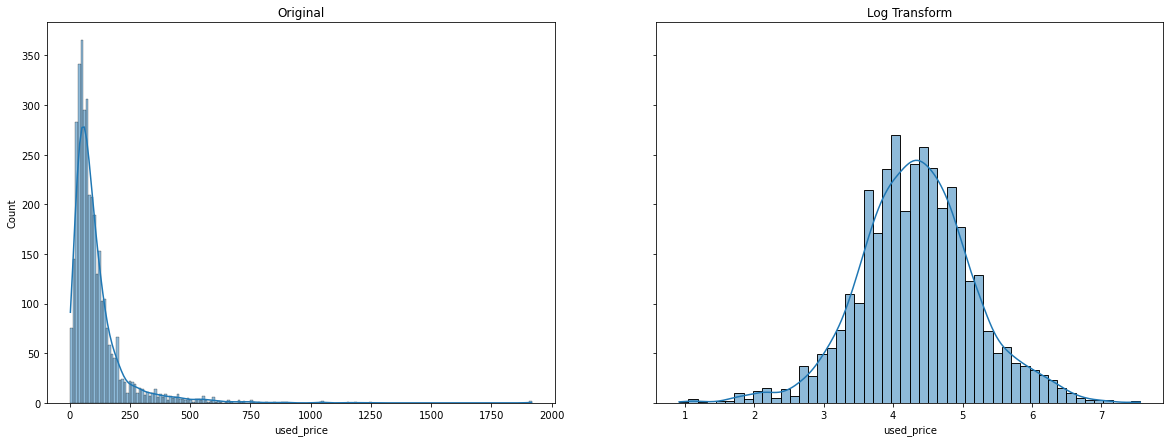

In [254]:
# Plot the original and transformed data
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (20,7))

ax1.set_title('Original')
ax2.set_title('Log Transform')


sns.histplot(data, x = 'used_price', ax = ax1, kde = True)
sns.histplot(data, x = np.log(data['used_price']), ax = ax2, kde = True)

plt.show()

Similar to new price, used price is much more normal after the log transformation, therefore we will keep the transformed data.

In [255]:
# Create new column for transformed data and drop unneeded column
data['used_price_log'] = np.log(data['used_price'])
data.drop('used_price', axis = 1, inplace = True)

Days Used

The days used variable is another variable where the scaling can be adjusted to match the rest of the dataset. I will turn it into years by dividing the days value by 365.

In [256]:
# Create new column with transformed data
data['years_used'] = data['days_used'] / 365

In [257]:
# Drop unneeded columns
data.drop('days_used', axis = 1, inplace = True)

One last look...

In [258]:
data.sample(5)

,brand_name,os,main_camera_mp,selfie_camera_mp,int_memory,ram,release_year,screen_size_in,network,battery_minmax,weight_minmax,new_price_log,used_price_log,years_used
1714,LG,Android,13.000,5.000,32.000,4.000,2017,5.126,4g,0.245,0.133,5.520,4.603,2.036
3478,LG,Android,8.000,32.000,128.000,6.000,2019,6.252,4g,0.329,0.182,6.583,6.292,0.529
1267,HTC,Android,13.000,8.000,16.000,4.000,2014,5.311,4g,0.211,0.142,5.832,4.628,2.542
1466,Huawei,Android,8.000,1.000,32.000,4.000,2013,6.063,Other,0.333,0.189,5.445,4.244,2.600
1986,Micromax,Android,5.000,0.300,16.000,4.000,2013,5.000,Other,0.245,0.102,4.506,3.587,2.107


- Outlier detection and treatment (if needed)


In [259]:
# Re-initialize the num_cols variable after manipulating the data. 

num_cols = data.select_dtypes(include = np.number).columns.tolist()
num_cols

['main_camera_mp',
 'selfie_camera_mp',
 'int_memory',
 'ram',
 'screen_size_in',
 'battery_minmax',
 'weight_minmax',
 'new_price_log',
 'used_price_log',
 'years_used']

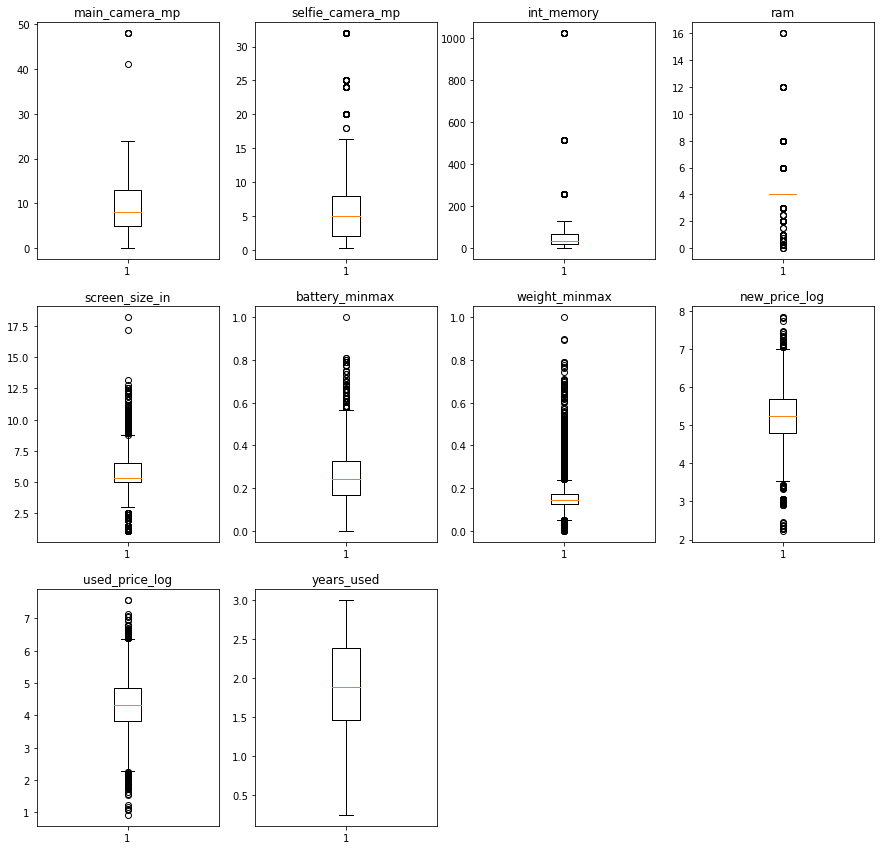

In [260]:
# Check out the box plots of the numerical data columns

plt.figure(figsize=(15, 20))

for i, variable in enumerate(num_cols):
    plt.subplot(4, 4, i + 1)
    plt.title(variable)
    plt.boxplot(data = data, x = variable)
    

plt.show()

In [261]:
# treat_outliers and treat_outliers_all functions are courtesy of GreatLearning Lectures. 

def treat_outliers(df, col):
    """
    treats outliers in a variable
    col: str, name of the numerical variable
    df: dataframe
    col: name of the column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    treat outlier in all numerical variables
    col_list: list of numerical variables
    df: data frame
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

In [262]:
# Run the treat outliers functions and save it back to the original dataframe.
# outlier cols copied from above and editted - ram was untouched due to the categorical nature of the data. The remaining data was mostly continuous or had very few outliers.

outlier_cols = ['main_camera_mp',
                'selfie_camera_mp',
                'int_memory',
                'screen_size_in',
                'battery_minmax',
                'weight_minmax',
                'new_price_log',
                'used_price_log',
                'years_used']

data = treat_outliers_all(data, outlier_cols)

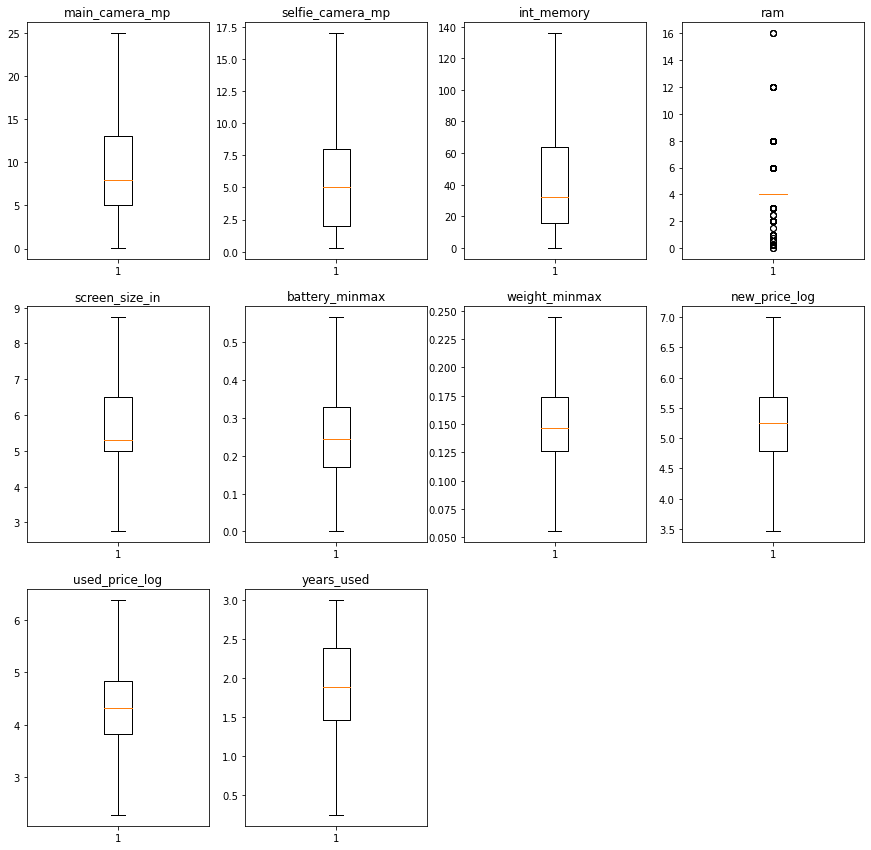

In [263]:
# Check out the box plots of the numerical variables after the flooring and capping. 

plt.figure(figsize=(15, 20))

for i, variable in enumerate(num_cols):
    plt.subplot(4, 4, i + 1)
    plt.title(variable)
    plt.boxplot(data = data, x = variable)
    

plt.show()

Distributions are now under control and we can move on to modeling! But first, lets look at the data one last time.

In [264]:
data.sample(5)

,brand_name,os,main_camera_mp,selfie_camera_mp,int_memory,ram,release_year,screen_size_in,network,battery_minmax,weight_minmax,new_price_log,used_price_log,years_used
1557,Lenovo,Android,13.000,8.000,64.000,4.000,2018,6.000,4g,0.309,0.165,5.015,4.323,1.189
2784,Sony,Android,23.000,8.000,64.000,4.000,2018,6.000,4g,0.294,0.196,5.942,5.248,1.523
50,Huawei,Android,13.000,8.000,64.000,4.000,2019,8.750,4g,0.568,0.245,5.705,5.420,0.562
2838,Sony,Android,20.700,0.300,16.000,4.000,2014,5.000,4g,0.245,0.151,5.526,4.832,1.556
1680,Lenovo,Android,5.000,0.300,16.000,4.000,2013,4.311,Other,0.161,0.115,5.021,3.815,2.586


- Preparing data for modeling

In [265]:
# Create the dependent and independent variables. 

X = data.drop('used_price_log', axis = 1)
y = data['used_price_log']

In [266]:
# Check out the shape each variable
print(X.shape)
print(y.shape)

(3571, 13)
(3571,)


In [267]:
# Use one-hot encoding on the categorical data and check the first few rows
X = pd.get_dummies(
    X, 
    columns=X.select_dtypes(include= 'category').columns.tolist(),
    drop_first=True,
)
X.head()

,main_camera_mp,selfie_camera_mp,int_memory,ram,screen_size_in,battery_minmax,weight_minmax,new_price_log,years_used,brand_name_Alcatel,...,os_iOS,release_year_2014,release_year_2015,release_year_2016,release_year_2017,release_year_2018,release_year_2019,release_year_2020,network_Both,network_Other
0,13.000,5.000,64.000,3.000,8.750,0.247,0.133,4.715,0.348,0,...,0,0,0,0,0,0,0,1,0,0
1,13.000,16.000,128.000,8.000,8.750,0.354,0.205,5.519,0.890,0,...,0,0,0,0,0,0,0,1,1,0
2,13.000,8.000,128.000,8.000,8.750,0.346,0.205,5.885,0.444,0,...,0,0,0,0,0,0,0,1,1,0
3,13.000,8.000,64.000,6.000,8.750,0.568,0.245,5.631,0.945,0,...,0,0,0,0,0,0,0,1,1,0
4,13.000,8.000,64.000,3.000,6.189,0.413,0.175,4.948,0.803,0,...,0,0,0,0,0,0,0,1,0,0


- Any other preprocessing steps (if needed)

## EDA

- It is a good idea to explore the data once again after manipulating it.

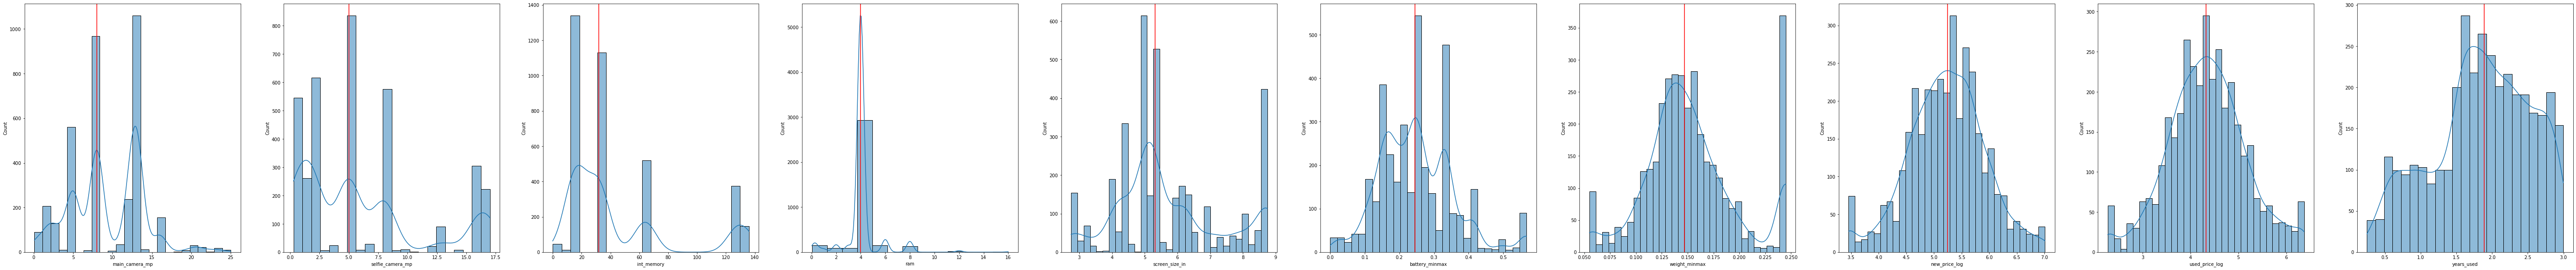

In [268]:
# Gather the float datatype columns and save them to a list.
# Call the hist_plot function to get the distributions of each of the float variables - double-click to expand the charts.

float_cols = data.select_dtypes(include = float).columns.tolist()

hist_plots(data, float_cols)

Compared to the original data, there are more float columns and more of them appear normal-ish.

Some of the data is numerical but appears categorical.

In [269]:
# # Gather the columns that are a number (ie. int or float)

# pairplot_data = data.select_dtypes(include = np.number)
# sns.pairplot(data = pairplot_data);

In [270]:
cat_cols = data.select_dtypes(include = 'category').columns.tolist()
cat_cols

['brand_name', 'os', 'release_year', 'network']

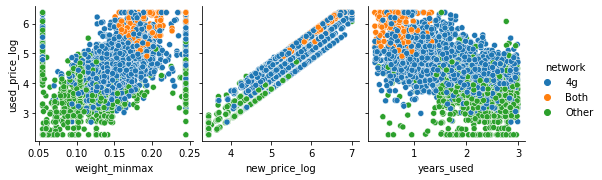

In [271]:
# Plot interesting interactions between variables
sns.pairplot(data = data, x_vars = ['weight_minmax', 'new_price_log', 'years_used'], y_vars = 'used_price_log', hue = 'network');

Isolating the used price and showing the relationship with weight, new price, and years with a network filter shows mostly linear relationships. 

The introduction of 5g in the recent years follows the trend of years released as well. 

## Building a Linear Regression model

In [167]:
# Split the data 70/30
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

In [168]:
#Use statsmodels to build a regression model. 
# Manually add a constant to the training data set.

x_train1 = sm.add_constant(x_train)
# adding constant to the test data
x_test1 = sm.add_constant(x_test)

olsmod0 = sm.OLS(y_train, x_train1).fit()
print(olsmod0.summary())

                            OLS Regression Results                            
Dep. Variable:         used_price_log   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3811.
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:32:26   Log-Likelihood:                 2541.8
No. Observations:                2499   AIC:                            -4974.
Df Residuals:                    2444   BIC:                            -4653.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.19

Wow! Already a 98.8% R-squared and adjusted R-squared.

## Model performance evaluation

In [169]:
# The following group of functions for linear regression metrics are courtesy of GreatLearning.

# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [170]:
# Check model performance on train set
print("Training Performance\n")
linearregression_train_perf = model_performance_regression(
    olsmod0, x_train1, y_train
)
linearregression_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.088,0.070,0.988,0.988,1.734


In [171]:
# Check model performance on test set
print("Test Performance\n")
linearregression_train_perf = model_performance_regression(
    olsmod0, x_test1, y_test
)
linearregression_train_perf

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.092,0.075,0.987,0.986,1.837


Very happy with the current model, but need to check the assumtions of linear regression

## Checking Linear Regression Assumptions

- In order to make statistical inferences from a linear regression model, it is important to ensure that the assumptions of linear regression are satisfied.

Multicollinearity

In [172]:
# Import the variance inflation factor package from stats models. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# The following function is used courtesy of GreatLearning

# we will define a function to check VIF
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif.sort_values('VIF', ascending = False)

In [173]:
# The following function is used courtesy of GreatLearning.
# When presented with the wheel, you don't reinvent the wheel.

def treating_multicollinearity(predictors, target, high_vif_columns):
    """
    Checking the effect of dropping the columns showing high multicollinearity
    on model performance (adj. R-squared and RMSE)

    predictors: independent variables
    target: dependent variable
    high_vif_columns: columns having high VIF
    """
    # empty lists to store adj. R-squared and RMSE values
    adj_r2 = []
    rmse = []

    # build ols models by dropping one of the high VIF columns at a time
    # store the adjusted R-squared and RMSE in the lists defined previously
    for cols in high_vif_columns:
        # defining the new train set
        train = predictors.loc[:, ~predictors.columns.str.startswith(cols)]

        # create the model
        olsmodel = sm.OLS(target, train).fit()

        # adding adj. R-squared and RMSE to the lists
        adj_r2.append(olsmodel.rsquared_adj)
        rmse.append(np.sqrt(olsmodel.mse_resid))

    # creating a dataframe for the results
    temp = pd.DataFrame(
        {
            "col": high_vif_columns,
            "Adj. R-squared after_dropping col": adj_r2,
            "RMSE after dropping col": rmse,
        }
    ).sort_values(by="Adj. R-squared after_dropping col", ascending=False)
    temp.reset_index(drop=True, inplace=True)

    return temp

In [174]:
# Call the checking vif function and save to a dataframe.

vif_df = checking_vif(x_train1)
vif_df.head()

,feature,VIF
0,const,282.123
11,brand_name_Apple,23.372
45,os_iOS,21.937
33,brand_name_Others,9.599
36,brand_name_Samsung,7.901


In [175]:
# Generate column list where VIF is greater than 5
col_list = vif_df[vif_df['VIF'] >= 5]['feature'].tolist()

# Remove the constant if it shows up as the first row. Otherwise comment the next line out.
# col_list.pop(0)

# Perform the multicollinearity function to determine the impact of removing variables
res = treating_multicollinearity(x_train1, y_train, col_list)
res.head()

,col,Adj. R-squared after_dropping col,RMSE after dropping col
0,const,1.000,0.089
1,brand_name_Apple,0.988,0.088
2,brand_name_Huawei,0.988,0.088
3,os_iOS,0.988,0.088
4,brand_name_LG,0.988,0.088


In [176]:
# Drop a column with the least ammount of impact to the r2 and RMSE.
# Repeat the sequence until there are no more vif features >= 5.
# The following sequence courtesy of GreatLearning
col_to_drop = "brand_name_Apple"
x_train2 = x_train1.loc[:, ~x_train1.columns.str.startswith(col_to_drop)]
x_test2 = x_test1.loc[:, ~x_test1.columns.str.startswith(col_to_drop)]

# Check VIF again and save to a new dataframe
vif_df2 = checking_vif(x_train2)
print("VIF after dropping ", col_to_drop)
vif_df2.head()

VIF after dropping  brand_name_Apple


,feature,VIF
0,const,282.078
32,brand_name_Others,9.147
35,brand_name_Samsung,7.479
19,brand_name_Huawei,5.808
50,release_year_2019,5.176


In [177]:
# There are still VIF values over 5
col_list = vif_df2[vif_df2['VIF'] >= 5]['feature'].tolist()

res = treating_multicollinearity(x_train2, y_train, col_list)
res.head()

,col,Adj. R-squared after_dropping col,RMSE after dropping col
0,const,1.000,0.089
1,brand_name_Huawei,0.988,0.088
2,brand_name_Others,0.988,0.088
3,brand_name_Samsung,0.988,0.088
4,release_year_2019,0.988,0.089


In [178]:
col_to_drop = "brand_name_Huawei"
x_train3 = x_train2.loc[:, ~x_train2.columns.str.startswith(col_to_drop)]
x_test3 = x_test2.loc[:, ~x_test2.columns.str.startswith(col_to_drop)]

vif_df3 = checking_vif(x_train3)
print("VIF after dropping ", col_to_drop)
vif_df3.head()

VIF after dropping  brand_name_Huawei


,feature,VIF
0,const,218.526
49,release_year_2019,5.173
50,release_year_2020,4.719
2,selfie_camera_mp,4.048
5,screen_size_in,3.867


In [179]:
# Still values over 5
col_list = vif_df3[vif_df3['VIF'] >= 5]['feature'].tolist()

res = treating_multicollinearity(x_train3, y_train, col_list)
res.head()

,col,Adj. R-squared after_dropping col,RMSE after dropping col
0,const,1.000,0.089
1,release_year_2019,0.988,0.089


In [180]:
col_to_drop = "release_year_2019"
x_train4 = x_train3.loc[:, ~x_train3.columns.str.startswith(col_to_drop)]
x_test4 = x_test3.loc[:, ~x_test3.columns.str.startswith(col_to_drop)]

vif_df4 = checking_vif(x_train4)
print("VIF after dropping ", col_to_drop)
vif_df4.head()

VIF after dropping  release_year_2019


,feature,VIF
0,const,171.108
5,screen_size_in,3.772
6,battery_minmax,3.614
2,selfie_camera_mp,3.334
7,weight_minmax,3.158


All VIF variables are now below 5, indicating low multicollinearity. 

Now is time to look at the model again with the multicollinearity removed.

In [181]:
#Create a new model with the multicollinearity removed.

olsmod1 = sm.OLS(y_train, x_train4).fit()
print(olsmod1.summary())

                            OLS Regression Results                            
Dep. Variable:         used_price_log   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     4018.
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:32:28   Log-Likelihood:                 2535.1
No. Observations:                2499   AIC:                            -4966.
Df Residuals:                    2447   BIC:                            -4663.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.14

Remove High P-value

In [272]:
# The following sequence is courtesy of GreatLearning.
# initial list of columns
cols = x_train4.columns.tolist()

# setting an initial max p-value
max_p_value = 1

while len(cols) > 0:
    # defining the train set
    x_train_aux = x_train4[cols]

    # fitting the model
    model = sm.OLS(y_train, x_train_aux).fit()

    # getting the p-values and the maximum p-value
    p_values = model.pvalues
    max_p_value = max(p_values)

    # name of the variable with maximum p-value
    feature_with_p_max = p_values.idxmax()

    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break

selected_features = cols
print(selected_features)

['const', 'selfie_camera_mp', 'screen_size_in', 'new_price_log', 'years_used', 'brand_name_Gionee', 'os_Others', 'release_year_2016', 'release_year_2017', 'release_year_2018', 'release_year_2020']


In [275]:
len(selected_features)

11

In [183]:
# Create a new dataframe with the features identified as having an impact on the model.
x_train5 = x_train4[selected_features]
x_test5 = x_test4[selected_features]

In [184]:
# Fit the model and display the results

olsmod2 = sm.OLS(y_train, x_train5).fit()
print(olsmod2.summary())

                            OLS Regression Results                            
Dep. Variable:         used_price_log   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 2.034e+04
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:32:29   Log-Likelihood:                 2505.1
No. Observations:                2499   AIC:                            -4988.
Df Residuals:                    2488   BIC:                            -4924.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1623      0.01

The model has been pared down to only a small fraction of the original variables.

The r-squared value remains the same, which is desireable.

Test for Linearity and independence

To test for linearity and independence, the residuals need plotted. If the plot has a pattern to it, the data is not linear and needs transformed.

In [185]:
# Create a dataframe with actual, fitted and residual values
pred = pd.DataFrame()

pred["Actual Values"] = y_train  # actual values
pred["Fitted Values"] = olsmod2.fittedvalues  # predicted values
pred["Residuals"] = olsmod2.resid  # residuals

pred.head()

,Actual Values,Fitted Values,Residuals
1248,4.594,4.627,-0.033
2206,4.887,4.882,0.005
1623,3.230,3.316,-0.087
2245,4.647,4.552,0.095
1043,3.669,3.775,-0.105


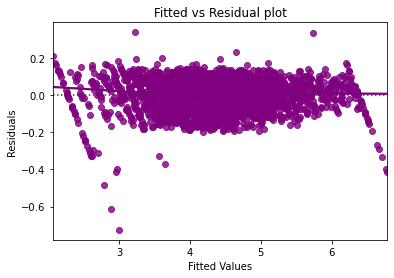

In [186]:
# Plot the fitted values vs residuals

sns.residplot(
    data=pred, x="Fitted Values", y="Residuals", color="purple", lowess=True
)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residual plot")
plt.show()

Since the residuals are mostly randomly distributed around 0, the linearity and independence assumption is satisfied.

Test for Normality

To test for normality, a histogram of the residuals must be plotted. If the data appears normal, the assumption is satisfied.

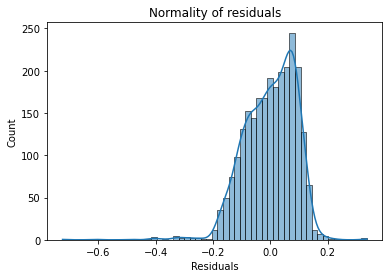

In [187]:
# Plot a histogram of the residuals
sns.histplot(data=pred, x="Residuals", kde=True)
plt.title("Normality of residuals")
plt.show()

The histogram roughly follows a bell curve. There does appear to be some left-skew to the distribution.

Normality can also be checked with a propability plot. 

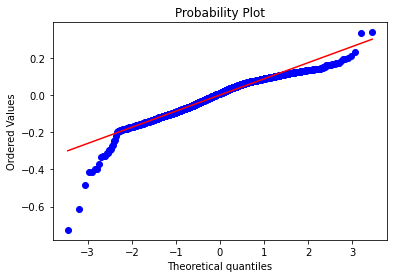

In [188]:
# Import the packages to perform the probability (Q-Q) plot.
import pylab
import scipy.stats as stats

# Plot the residuals compared to normal
stats.probplot(pred["Residuals"], dist="norm", plot=pylab)
plt.show()

Based on the Q-Q plot, the data mostly follows normality with the exception of the tails of the data. This was also seen in the residual distribution.

One final test of normality is the Shapiro-Wilkes test:

In [189]:
stats.shapiro(pred["Residuals"])

ShapiroResult(statistic=0.9533571004867554, pvalue=1.5573972791459107e-27)

Since the value is not greater than 0.05, the distribution is technically non-normal. 

However, for the purposes of this model, it is close enough to proceed and consider the assumption satisfied.

Test for Homoscedasticity

The basic test for homoscedasticity is the Goldfeld-Quandt test:

In [190]:
# Import the necessary packages to perform the test
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

# Perform the test
name = ["f_stat", "p-value"]
test = sms.het_goldfeldquandt(pred["Residuals"], x_train5)
lzip(name, test)

[('f_stat', 1.0142942070665066), ('p-value', 0.40141009847352277)]

Since the p-value is greater than 0.05, the data is homoscedastic and the assumption is satisfied.

Time to look at the preditions vs. the actual values to see how well the model is performing.

In [191]:
# predictions on the test set
pred = olsmod2.predict(x_test5)

pred_test = pd.DataFrame({"Actual": y_test, "Predicted": pred})
pred_test.sample(10)

,Actual,Predicted
457,3.658,3.574
349,6.316,6.273
2170,3.019,2.884
2589,3.776,3.626
2455,5.697,5.601
1828,4.608,4.658
2207,4.395,4.320
187,4.272,4.186
1496,3.868,4.008
3269,4.605,4.528


The displayed predicted values are typically very close to the actual values in the dataset. The model is complete and ready to be rolled out.

## Final Model Summary

In [192]:
# checking the final model performance on train set
print("Train Performance\n")
olsmod2_test_perf = model_performance_regression(olsmod2, x_train5, y_train)
olsmod2_test_perf

Train Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.089,0.072,0.988,0.988,1.763


In [193]:
# checking the final model performance on test set
print("Test Performance\n")
olsmod2_test_perf = model_performance_regression(olsmod2, x_test5, y_test)
olsmod2_test_perf

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.092,0.074,0.987,0.987,1.826


In [194]:
# Create the final model and display the summary data. 
olsmod_final = sm.OLS(y_train, x_train5).fit()
print(olsmod_final.summary())

                            OLS Regression Results                            
Dep. Variable:         used_price_log   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 2.034e+04
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:32:31   Log-Likelihood:                 2505.1
No. Observations:                2499   AIC:                            -4988.
Df Residuals:                    2488   BIC:                            -4924.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1623      0.01

## Actionable Insights and Recommendations


Based on the provided data, this model is able to predict phone sales with an accuracy (adjusted r-squared) of nearly 98.7%

This model can successfully predict the price a phone will sell for and the factors that influce that sale.

Here are the high-level findings:

<ul>
    <li>The biggest influence that increase a phones selling price, is the original sale price. As the new phone price goes up, the used phone price will also rise.</li>
    <li>Other positive influences include higher MP selfie cameras, larger screen sizes, and newer phones in general.</li>
    <li>Some negative influences on phone price include age, non-standard operating sytems, and certain brands (Gionee).</li>
</ul>

As a result of these findings, my recommendations to fetch better pricing of phones are the following:

<ul>
    <li>Sell the most recent phones quickly, a single year difference in model can significantly impact the sale price.</li>
    <li>Larger screens are desireable.</li>
    <li>Only sell phones that are recognized brands that run recognized operating systems.</li>
</ul>